# Midterm 3

Assignment: 2

Author: Dumitru Ana-Maria

## 0. Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

import os
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu, sigmoid

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch.optim import Adam

## 1. Importing the dataset

We will import the data and save the images and masks into 2 NumPy arrays. We will display a mask and its corresponding image to check that everything is okay.

In [ ]:
path_horse = r"weizmann_horse_db\horse"
path_mask = r"weizmann_horse_db\mask"

images_list_names = [f.path for f in os.scandir(path_horse)]
masks_list_names = [f.path for f in os.scandir(path_mask)]

images_list_names.sort()
masks_list_names.sort()

images_data = []
masks_data = []

for i in range(len(images_list_names)):
  img = Image.open(images_list_names[i])
  msk = Image.open(masks_list_names[i])

  image = np.asarray(img)
  images_data.append(image)

  mask = np.asarray(msk)
  masks_data.append(mask)

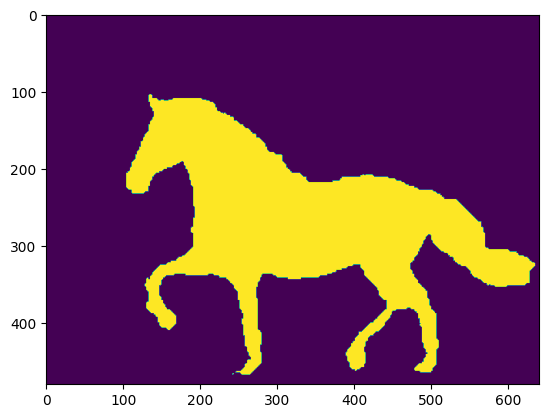

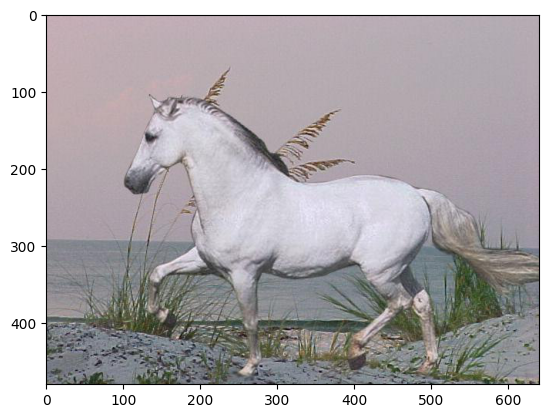

In [ ]:
plt.imshow(masks_data[100])
plt.show()
plt.imshow(images_data[100])
plt.show()

## 2. Creating the U-Net Class

We will first create a U-Net class, which will be able to distinguish the horse in the images from the background. It is derived from the class nn.Module.

In [ ]:
class UNet(nn.Module):
  """
    A U-Net convolutional network model. It is made out of an Encoder part,
    which learns the "what" part of the image (what the elements of the image
    are), and a Decoder part, which is in charge of the "where" part of the
    image (where in the image are the elements positioned). 0 padding will be
    used such that the final feature map is not cropped and to eliminate any
    post-processing needs to the output image
  """

  def __init__(self):
    super().__init__()

    # Step 1: Encoder
    """
        There will be 5 blocks: the first 4 will contain 2 convolutional layers
        and a max pooling layer, and the last one will have only the 2
        convolutional layers. The size of the resulting image will be shown
        after every layer for clarity.
        Due to the padding, the formulas used are:
          - For convolutions: W' = (W - K + 2P)/S + 1 (K = 3, P = 1, S = 1)
          - For max pooling:  W' = (W - K)/S + 1 (K = 2, S = 2)
    """
    # Starting size: 572 x 572 x 1 (length x width x depth)

    # Block 1:
    # Input size: 572 x 572 x 1
    self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # output: 572 x 572 x 64
    self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 572 x 572 x 64
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # output: 286 x 286 x 64

    # Block 2:
    # Input size: 286 x 286 x 64
    self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # output: 286 x 286 x 128
    self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 286 x 286 x 128
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)    # output: 143 x 143 x 128

    # Block 3:
    # Input size: 143 x 143 x 128
    self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # output: 143 x 143 x 256
    self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # output: 143 x 143 x 256
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)     # output:  71 x  71 x 256

    # Block 4:
    # This is the last block where we perform max pooling
    # Input size: 71 x 71 x 256
    self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # output: 71 x 71 x 512
    self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)  # output: 71 x 71 x 512
    self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)     # output: 35 x 35 x 512

    # Block 5:
    # This is the block from where we will start performing up convolution
    # There is no max pooling here
    # Input Size: 35 x 35 x 512
    self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)  # output: 35 x 35 x 1024
    self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 35 x 35 x 1024

    # Step 2: Decoder
    """
        There will be 4 blocks, each one containing 2 convolutional layers and
        an up-convolution layer. The size of the image will be again shown after
        every operation for clarity.

        Formulas used:
        - For up-convolution: W' = (W - 1) * S + 1 (S = 2)
        - FOr convolutions: W' = (W - K + 2P)/S + 1 (K = 3, P = 1, S = 1)
    """
    # Starting size: 35 x 35 x 1024

    # Block 1:
    # Input size: 35 x 35 x 1024
    self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 69 x 69 x 512
    self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)             # output: 69 x 69 x 512
    self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)              # output: 69 x 69 x 512

    # Block 2:
    # Input size: 69 x 69 x 512
    self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 137 x 137 x 256
    self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)             # output: 137 x 137 x 256
    self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)             # output: 137 x 137 x 256

    # Block 3:
    # Input size: 137 x 137 x 256
    self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 273 x 273 x 128
    self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)             # output: 273 x 273 x 128
    self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)             # output: 273 x 273 x 128

    # Block 4:
    # Input size: 273 x 273 x 128
    self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 545 x 545 x 64
    self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)             # output: 545 x 545 x 64
    self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)              # output: 545 x 545 x 64

    # Output layer:
    # No more padding here
    # New formula: W' = (W - K)/S + 1 (K = 1, S = 1)
    self.outconv = nn.Conv2d(64, 1, kernel_size=1)      # output: 545 x 545 x 2

  def cat_accordingly(self, x1, x2):
    """
        Pads x2 according to the size of x1
    """
    diffY = x2.size()[2] - x1.size()[2] # position 2: height
    diffX = x2.size()[3] - x1.size()[3] # position 3: width
    x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
    diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1) # on dim=1 because that is the depth
                                   # dim=0 is the batch size
    return x

  def forward(self, x):
    """
        The Forward Method: used to specify how the input is processed
    """

    # Step 1: Encoder
    x_e11 = relu(self.e11(x))
    x_e12 = relu(self.e12(x_e11))
    x_pool1 = self.maxpool1(x_e12)

    x_e21 = relu(self.e21(x_pool1))
    x_e22 = relu(self.e22(x_e21))
    x_pool2 = self.maxpool2(x_e22)

    x_e31 = relu(self.e31(x_pool2))
    x_e32 = relu(self.e32(x_e31))
    x_pool3 = self.maxpool3(x_e32)

    x_e41 = relu(self.e41(x_pool3))
    x_e42 = relu(self.e42(x_e41))
    x_pool4 = self.maxpool4(x_e42)

    x_e51 = relu(self.e51(x_pool4))
    x_e52 = relu(self.e52(x_e51))

    # Step 2: Decoder
    x_u1 = self.upconv1(x_e52)
    x_u11 = self.cat_accordingly(x_u1, x_e42) # getting x_u1 at the same size as x_e42
    x_d11 = relu(self.d11(x_u11))
    x_d12 = relu(self.d12(x_d11))

    x_u2 = self.upconv2(x_d12)
    x_u22 = self.cat_accordingly(x_u2, x_e32)
    x_d21 = relu(self.d21(x_u22))
    x_d22 = relu(self.d22(x_d21))

    x_u3 = self.upconv3(x_d22)
    # x_u3 = self.upconv3(x_pool3)
    x_u33 = self.cat_accordingly(x_u3, x_e22)
    x_d31 = relu(self.d31(x_u33))
    x_d32 = relu(self.d32(x_d31))

    x_u4 = self.upconv4(x_d32)
    x_u44 = self.cat_accordingly(x_u4, x_e12)
    x_d41 = relu(self.d41(x_u44))
    x_d42 = relu(self.d42(x_d41))

    # Step 3: Output layer
    out = self.outconv(x_d42)
    return out

## 3. Training & Testing the Model

We will split the data into train and test: the masks will be the labels from y and the images will be the data to be learnt and tested from X.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_data, masks_data, test_size=0.33, random_state=42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = UNet().to(device)

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

cuda


The training part was executed on my own device before Google Colab decided not to allow me to use their GPUs anymore with my account. The second time training was performed took place on another, more powerful device, and the output can be seen below. On that same device, we saved the model with the best loss and the script, together with the model, were sent back to my device.

In [ ]:
model.train()

best_loss = 1000.
epoch_losses = []
for epoch in range(100):
  loss_sum = 0

  for i, elem in enumerate(X_train):
    elem = np.float32(elem) / 255
    elem = torch.tensor(elem).transpose(2, 0).to(device)
    elem = torch.unsqueeze(elem, 0)

    y_pred = model(elem)
    y_pred = sigmoid(y_pred)

    output = np.float32(y_train[i])
    output = torch.tensor(output).transpose(1, 0).to(device)
    output = torch.unsqueeze(output, 0)
    output = torch.unsqueeze(output, 0)

    loss = criterion(y_pred, output)
    loss_sum += loss.cpu().detach().numpy()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_loss = loss_sum / len(X_train)
  epoch_losses.append(avg_loss)

  if best_loss > avg_loss:
    best_loss = avg_loss
    torch.save(model.state_dict(), r"model.pt")

  print("Epoch {} Avg. Loss: {}".format(epoch, avg_loss))

c:\Users\spiri\anaconda3\envs\Ana\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\spiri\anaconda3\envs\Ana\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 Avg. Loss: 0.5317946457427386
Epoch 1 Avg. Loss: 0.4565841389573328
Epoch 2 Avg. Loss: 0.40173644569094324
Epoch 3 Avg. Loss: 0.38562405548275336
Epoch 4 Avg. Loss: 0.3678947667757126
Epoch 5 Avg. Loss: 0.3598693708238536
Epoch 6 Avg. Loss: 0.3512464845085253
Epoch 7 Avg. Loss: 0.3350719974533608
Epoch 8 Avg. Loss: 0.32366219720884
Epoch 9 Avg. Loss: 0.31040190143264046
Epoch 10 Avg. Loss: 0.2910279551325323
Epoch 11 Avg. Loss: 0.2774811810792581
Epoch 12 Avg. Loss: 0.2595605718898991
Epoch 13 Avg. Loss: 0.24613619835613526
Epoch 14 Avg. Loss: 0.22730203697534457
Epoch 15 Avg. Loss: 0.20909401867963953
Epoch 16 Avg. Loss: 0.19205346793684785
Epoch 17 Avg. Loss: 0.1723996043613512
Epoch 18 Avg. Loss: 0.1647276529302336
Epoch 19 Avg. Loss: 0.14730526957677925
Epoch 20 Avg. Loss: 0.13146108371039775
Epoch 21 Avg. Loss: 0.11914859234130001
Epoch 22 Avg. Loss: 0.11451780242360618
Epoch 23 Avg. Loss: 0.10340898472084302
Epoch 24 Avg. Loss: 0.09859730468288949
Epoch 25 Avg. Loss: 0.08

Due to the fact that the real training for the model was performed on another device and I forgot to plot the losses in this file when I had the chance, I will add a figure below, plotted later on on the device used for training.

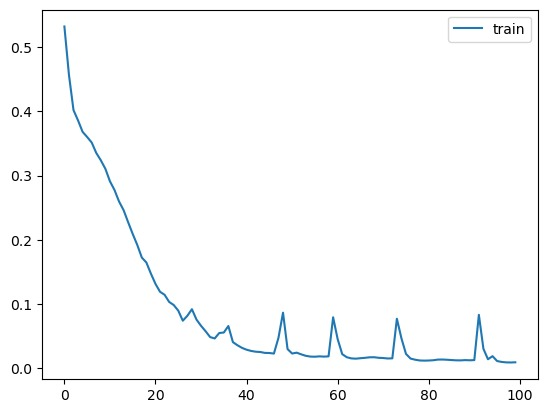

We notice that the loss learns pretty well up until epoch 40, after which it loses smoothness and appear sime strange peaks. They are probably the result of a high learning rate.

We are now going to test the model on 2 images. First, we will load the previously saved one.

In [ ]:
# Loading the model
model.load_state_dict(torch.load(r"C:\Users\Big Lion\ISPR\My models\model.pt"))

<All keys matched successfully>

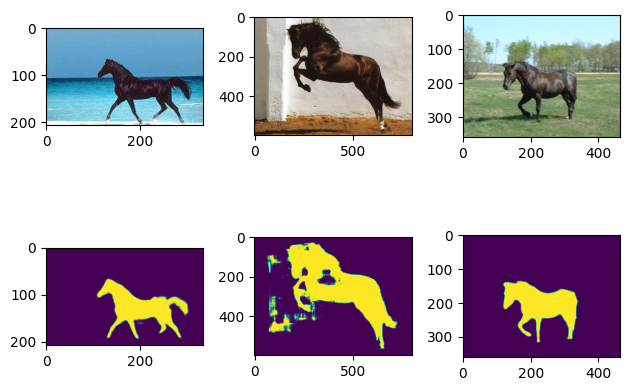

In [ ]:
idx_list = [2, 10, 100]

fig, axs = plt.subplots(2, 3)

for i, idx in enumerate(idx_list):
  elem = X_test[idx]
  axs[0, i].imshow(elem)

  model.eval()
  with torch.no_grad():
    elem = np.float32(elem) / 255
    elem = torch.tensor(elem).transpose(2, 0).to(device)
    elem = torch.unsqueeze(elem, 0)

    y_pred = model(elem)
    y_pred = sigmoid(y_pred)
    y_pred = y_pred.cpu().detach().squeeze().transpose(0, 1).numpy()

  axs[1, i].imshow(y_pred)
plt.tight_layout()
plt.show()

We notice that the model performs quite well on some of the images, where the horse really stands out from the background. My take is that, if the colour of the horse is very different from the background (blue backgroun-dark brown horse, light background-dark horse), the model will be able to tell, with high accuracy, where the horse is exactly, and draw a precise contour around it.

When the color palette is similar, like in the second set of plots (dark brown horse, and background made out of various shades of brown, orange and ivory), the model will have a harder time distinguishing the horse from the background.

We will check the accuracy of the model with 2 metrics: Intersection over Union (IoU) and Dice Score.

## 4. Metrics

First, we will define the functions that will be used for this section:

In [ ]:
def intersection(x: np.array, y: np.array):
    """
       Performs the intersection between 2 numpy arrays and returns the number of elements.
    """
    return (x & y).sum()

def union(x, y):
    """
       Performs the union between 2 numpy arrays and returns the number of elements.
    """
    return (x | y).sum()

In [ ]:
def iou_score(pred: np.array, labels: np.array):
    """
        Computes the Intersection over Union score for the prediction and the label of the image.
    """
    return (intersection(pred, labels) + 1e-6) / (union(pred, labels) + 1e-6) # avoid 0 or inf values with 1e-6

In [ ]:
def dice_score(pred: np.array, labels: np.array):
    """
        Computes the Dice score for the prediction and the label of the image.
    """
    return (2 * intersection(pred, labels) + 1e-6) / (union(pred, labels) + intersection(pred, labels) + 1e-6) # avoid 0 or inf values with 1e-6

We will store the predictions for all the elements in the test set in an array, due to the fact that we will use them both for the IoU score and for the Dice score.

In [ ]:
y_pred_list = []
with torch.no_grad():
    for elem in X_test:
        elem = np.float32(elem) / 255
        elem = torch.tensor(elem).transpose(2, 0).to(device)
        elem = torch.unsqueeze(elem, 0)

        y_pred = model(elem)

        y_pred = sigmoid(y_pred)
        y_pred = y_pred.cpu().detach().squeeze().transpose(0, 1).numpy()
        y_pred = (y_pred >= 0.5).astype(np.uint)
        y_pred_list.append(y_pred)

### 4.1. Intersection Over Union (IoU) Score

In [ ]:
sum_ious = 0
for i in range(len(X_test)):
    if i == 2:
        iou_2 = iou_score(y_pred_list[i], y_test[i])
    if i == 10:
        iou_10 = iou_score(y_pred_list[i], y_test[i])
    if i == 100:
        iou_100 = iou_score(y_pred_list[i], y_test[i])

    iou_elem = iou_score(y_pred_list[i], y_test[i])
    sum_ious += iou_elem

avg_iou = sum_ious / len(X_test)

In [ ]:
print("Average IoU score: {} \n".format(avg_iou))
print("IoU score for third image: {} \n".format(iou_2))
print("IoU score for the 11th image: {} \n".format(iou_10))
print("IoU score for the 101th image: {} \n".format(iou_100))

Average IoU score: 0.8318357887043407 

IoU score for third image: 0.8675382101444258 

IoU score for the 11th image: 0.8174460848742564 

IoU score for the 101th image: 0.9463829369006103 



We notice that the average IoU score of the model is 0.83, which means that, even in its worst case performance, the model is still able to provide very good predictions with respect to the ground truth, on average.

If we look at the scores for the images in the example before (the third, 11th and 101st images in the dataset), we notice that the second one from the example scores the lowest in terms of IoU score, which is expected by the way it looks. However, the first image from the example has a score higher just with 0.05, and visually it looks way better than the image discussed before. This is due to the fact that IoU "punishes" harshly every pixel that is not correctly classified, and in the case of this image, the margins are not as well classified as the ones from the last image from the example, which scores the highest out of all three of them.

### 4.2. Dice Score

In [ ]:
sum_dices = 0
for i in range(len(X_test)):
    if i == 2:
        dice_2 = dice_score(y_pred_list[i], y_test[i])
    if i == 10:
        dice_10 = dice_score(y_pred_list[i], y_test[i])
    if i == 100:
        dice_100 = dice_score(y_pred_list[i], y_test[i])

    dice_elem = dice_score(y_pred_list[i], y_test[i])
    sum_dices += dice_elem

avg_dice = sum_dices / len(X_test)

In [ ]:
print("Average Dice score: {} \n".format(avg_dice))
print("Dice score for third image: {} \n".format(dice_2))
print("Dice score for the 11th image: {} \n".format(dice_10))
print("Dice score for the 101th image: {} \n".format(dice_100))

Average Dice score: 0.9040280693671947 

Dice score for third image: 0.9290714432813943 

Dice score for the 11th image: 0.8995547011568432 

Dice score for the 101th image: 0.9724529731101514 



We notice that the Dice scores for the same images considered before, as well as the average for the test set, are much higher than the IoU ones. This is due to the fact that this metric measures something closer to the average performance, so it is more lenient with the "punishments" than IoU.

The Dice score for the worst-predicted image out of the three from the example is now 0.899, which is lower than all three of them, but still very high in terms of accuracy scores. The average Dice score is 0.90, which means that, all in all, the model is able to perform semantic segmentation with a very high accuracy.

## 5. Personal Considerations

- Every time I mention that I do something for clarity, I refer to my own understanding of what is happening in this project, both for now and for the future.

- I warmed up to snake case with this project.

- It took around 1h 30min to train the model on 100 epochs on Google Colab, and the next day, when I tried to run the imports block, I received this error:

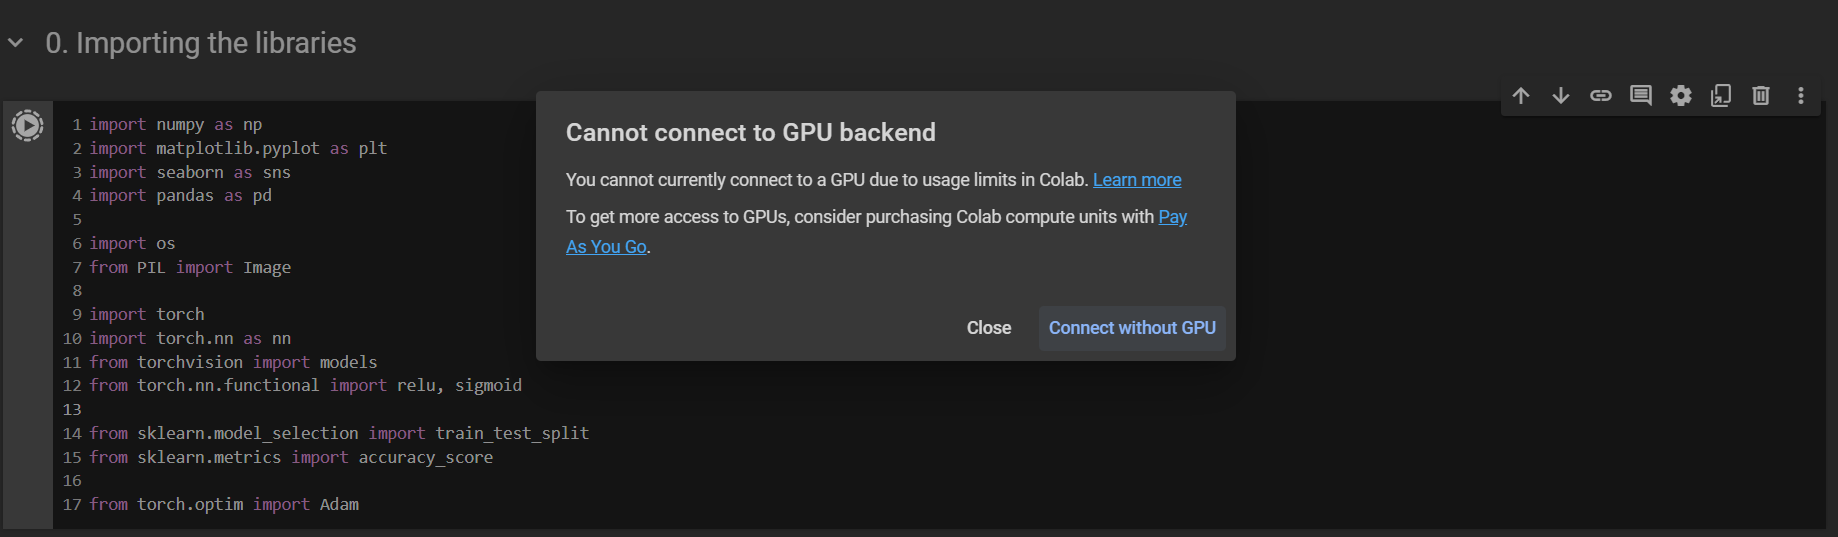

Apparently, I overused their resources and either already am or will be on their blacklist. I tried to work in Jupyter Notebook on my laptop, but it is quite weak for this task. On another laptop with better specifications, it managed to complete 40 epochs in 23 minutes (1 epoch in around 40s).

- After I sent the file with the completed training and the best model, I realised I forgot to plot the losses, so I had to borrow the laptop again to plot it and I decided to take a screenshot of it and upload it here. I hope it is not a problem.
